In [1]:
import deepSI
from deepSI.systems.system import System, System_deriv, System_data
import numpy as np
from matplotlib import pyplot as plt

In [2]:
#the system to generate the data (also included in )

from gym.spaces import Box
class Ball_in_box(System_deriv): 
    """docstring for Ball_in_box
    dvxdt = (1/x**2-1/(1-x)**2)/200+ux-self.gamma*vx
    dvydt = (1/y**2-1/(1-y)**2)/200+uy-self.gamma*vy
    """
    def __init__(self, Fmax=0.25, Nresist=0.7):
        self.Fmax = Fmax
        dt = 2*np.pi/20 #20 points in the sin
        self.gamma = Fmax*dt/0.1 # ux*dt/gamma = X=0.1
        super(Ball_in_box, self).__init__(dt=dt,nx=2)
        self.action_space = Box(float(-1),float(1),shape=(2,))

    def reset(self):
        self.x = [0.5,0.5,0,0] #[x,y,vx,vy]
        return self.h(self.x) #return position

    def deriv(self,x,u):
        ux,uy = np.clip(u,-1,1)*self.Fmax
        # print(u)
        x,y,vx,vy = x
        dvxdt = (1/x**2-1/(1-x)**2)/200+ux-self.gamma*vx
        dvydt = (1/y**2-1/(1-y)**2)/200+uy-self.gamma*vy
        return [vx,vy,dvxdt,dvydt]

    def h(self,x):
        return x[0],x[1] #return position

class Ball_in_box_video(Ball_in_box):
    """same as Ball_in_box but with video output
    """
    def __init__(self, Fmax=0.25):
        self.ny_vid, self.nx_vid = 25, 25
        super(Ball_in_box_video, self).__init__(Fmax=Fmax)
        self.observation_space = Box(0.,1.,shape=(self.nx_vid,self.ny_vid)) #overwrite output

    def h(self,x):
        Y = np.linspace(0,1,num=self.ny_vid)
        X = np.linspace(0,1,num=self.nx_vid)
        Y,X = np.meshgrid(Y,X)
        r = 0.22
        A = np.clip((r**2-(X-x[1])**2-(Y-x[0])**2)/r**2,0,1)
        return A #return array

## Generate/Load data

In [3]:
if True: #False to load data
    np.random.seed(seed=42)
    urand = lambda L: np.random.uniform(low=sys.action_space.low, high=sys.action_space.high, size=(L,2))
    sys = Ball_in_box_video()
    train = System_data(u=urand(30000))
    val = System_data(u=urand(5000))
    test = System_data(u=urand(5000))
    train = sys.apply_experiment(train)
    val = sys.apply_experiment(val)
    test = sys.apply_experiment(test)
    train.save('ball-in-box-data/train')
    val.save('ball-in-box-data/val')
    test.save('ball-in-box-data/test')
else:
    train = deepSI.load_system_data('ball-in-box-data/train.npz')
    val = deepSI.load_system_data('ball-in-box-data/val.npz')
    test = deepSI.load_system_data('ball-in-box-data/test.npz')

In [4]:
np.random.seed(42)
ystd = np.std(train.y.flat)
from copy import deepcopy

def get_noisy(datas,noise):
    datas_noise = [deepcopy(data) for data in datas]
    for data_noise in datas_noise:
        data_noise.y += np.random.normal(scale=ystd*noise,size=data_noise.y.shape)
    return datas_noise

train_5, val_5, test_5  = get_noisy([train,val,test],0.05)
train_20,val_20,test_20 = get_noisy([train,val,test],0.20)
train_50,val_50,test_50 = get_noisy([train,val,test],0.50)
train_100,val_100,test_100 = get_noisy([train,val,test],1.00)

## Fit state-space encoder

In [ ]:
dilation = 1 #this will skip n time steps between samples reducing memory usage considerably

def get_fit_sys_ss(nx=6):
    fit_sys = deepSI.fit_systems.SS_encoder(nx=nx, na=5, nb=5)
    fit_sys.use_norm = False #the norm will not be fitted automatically
    fit_sys.norm.y0 = np.mean(train.y) #fit global values
    fit_sys.norm.ystd = np.std(train.y)
    fit_sys.norm.u0 = np.mean(train.u,axis=0)
    fit_sys.norm.ustd = np.std(train.u,axis=0)
    return fit_sys

if False:
    fit_sys = get_fit_sys_ss()
    fit_sys.fit(train.flatten(),verbose=2, epochs=930, loss_kwargs=dict(nf=50,dilation=dilation),sim_val=val.flatten())
    fit_sys.save_system('systems/SS-encoder-sys') #prevent accidental overwrite is bad
else:
    fit_sys = deepSI.load_system('systems/SS-encoder-sys')

if False:
    fit_sys_5 = get_fit_sys_ss()
    fit_sys_5.fit(train_5.flatten(),verbose=2, epochs=240, loss_kwargs=dict(nf=50,dilation=dilation),sim_val=val_5.flatten())
    fit_sys_5.save_system('systems/SS-encoder-sys-5') #prevent accidental overwrite is bad
else:
    fit_sys_5 = deepSI.load_system('systems/SS-encoder-sys-5')
    
if False:
    fit_sys_20 = get_fit_sys_ss()
    fit_sys_20.fit(train_20.flatten(),verbose=2, epochs=240, loss_kwargs=dict(nf=50,dilation=dilation),sim_val=val_20.flatten())
    fit_sys_20.save_system('systems/SS-encoder-sys-20') #prevent accidental overwrite is bad
else:
    fit_sys_20 = deepSI.load_system('systems/SS-encoder-sys-20')

if False:
    fit_sys_50 = get_fit_sys_ss()
    fit_sys_50.fit(train_50.flatten(),verbose=2, epochs=240, loss_kwargs=dict(nf=50,dilation=dilation),sim_val=val_50.flatten())
    fit_sys_50.save_system('systems/SS-encoder-sys-50') #prevent accidental overwrite is bad
else:
    fit_sys_50 = deepSI.load_system('systems/SS-encoder-sys-50')

if False:
    fit_sys_100 = get_fit_sys_ss()
    fit_sys_100.fit(train_100.flatten(),verbose=2, epochs=240, loss_kwargs=dict(nf=50,dilation=dilation),sim_val=val_100.flatten())
    fit_sys_100.save_system('systems/SS-encoder-sys-100') #prevent accidental overwrite is bad
else:
    fit_sys_100 = deepSI.load_system('systems/SS-encoder-sys-100')

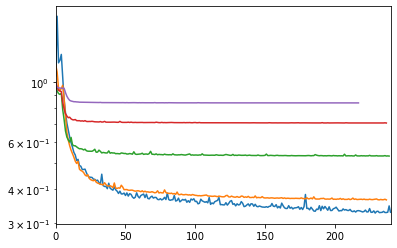

In [6]:
plt.semilogy(fit_sys.Loss_val)
plt.semilogy(fit_sys_5.Loss_val)
plt.semilogy(fit_sys_20.Loss_val)
plt.semilogy(fit_sys_50.Loss_val)
plt.semilogy(fit_sys_100.Loss_val)
plt.xlim(0,240)
plt.show()


In [7]:
test_5_ss = fit_sys_5.apply_experiment(test_5.flatten()).reshape_as(test_5)
test_20_ss = fit_sys_20.apply_experiment(test_20.flatten()).reshape_as(test_20)
test_50_ss = fit_sys_50.apply_experiment(test_50.flatten()).reshape_as(test_50)
test_100_ss = fit_sys_100.apply_experiment(test_100.flatten()).reshape_as(test_100)

## Fit Input-output autoencoder

Reproduction of: Wahlstrom, N., Schon, T.B., and Deisenroth, M.P.
(2015). Learning deep dynamical models from image
pixels. IFAC-PapersOnLine, 48(28), 1059–1064.

In [ ]:
def get_IO_sys():
    fit_sys_auto = deepSI.fit_systems.IO_autoencoder(nz=6, na=5, nb=5)
    fit_sys_auto.use_norm = False #the norm will not be fitted automatically
    fit_sys_auto.norm.y0 = np.mean(train.y) #fit global values
    fit_sys_auto.norm.ystd = np.std(train.y)
    fit_sys_auto.norm.u0 = np.mean(train.u,axis=0)
    fit_sys_auto.norm.ustd = np.std(train.u,axis=0)
    return fit_sys_auto

if False:
    fit_sys_auto = get_IO_sys()
    fit_sys_auto.fit(train.flatten(),verbose=2, epochs=15*600, loss_kwargs=dict(),sim_val=val.flatten())
    fit_sys_auto.save_system('systems/IO-autoencoder-sys') #overwrite is bad
    fit_sys_auto.checkpoint_load_system('_last')
    fit_sys_auto.save_system('systems/IO-autoencoder-sys-last')
    fit_sys_auto.checkpoint_load_system('_best')
#     fit_sys_auto_last = deepSI.load_system('systems/IO-autoencoder-sys-last')
else:
    fit_sys_auto = deepSI.load_system('systems/IO-autoencoder-sys')
fit_sys_auto_last = deepSI.load_system('systems/IO-autoencoder-sys-last') #epoch in time

if False:
    fit_sys_auto_5 = get_IO_sys()
    fit_sys_auto_5.fit(train_5.flatten(),verbose=2, epochs=1000, loss_kwargs=dict(),sim_val=val_5.flatten())
    fit_sys_auto_5.save_system('systems/IO-autoencoder-sys-5') #overwrite is bad
else:
    fit_sys_auto_5 = deepSI.load_system('systems/IO-autoencoder-sys-5')

if False:
    fit_sys_auto_20 = get_IO_sys()
    fit_sys_auto_20.fit(train_20.flatten(),verbose=2, epochs=1000, loss_kwargs=dict(),sim_val=val_20.flatten())
    fit_sys_auto_20.save_system('systems/IO-autoencoder-sys-20') #overwrite is bad
else:
    fit_sys_auto_20 = deepSI.load_system('systems/IO-autoencoder-sys-20')

if False:
    fit_sys_auto_50 = get_IO_sys()
    fit_sys_auto_50.fit(train_50.flatten(),verbose=2, epochs=1000, loss_kwargs=dict(),sim_val=val_50.flatten())
    fit_sys_auto_50.save_system('systems/IO-autoencoder-sys-50') #overwrite is bad
else:
    fit_sys_auto_50 = deepSI.load_system('systems/IO-autoencoder-sys-50')

if False:
    fit_sys_auto_100 = get_IO_sys()
    fit_sys_auto_100.fit(train_100.flatten(),verbose=2, epochs=1000, loss_kwargs=dict(),sim_val=val_100.flatten())
    fit_sys_auto_100.save_system('systems/IO-autoencoder-sys-100') #overwrite is bad
else:
    fit_sys_auto_100 = deepSI.load_system('systems/IO-autoencoder-sys-100')

In [9]:
test_SS_encoder, test_IO_auto = fit_sys.apply_experiment(test.flatten()).reshape_as(test), fit_sys_auto.apply_experiment(test.flatten()).reshape_as(test)
train_SS_encoder, train_IO_auto = fit_sys.apply_experiment(train.flatten()).reshape_as(train), fit_sys_auto.apply_experiment(train.flatten()).reshape_as(train)

In [10]:
test_5_auto = fit_sys_auto_5.apply_experiment(test_5.flatten()).reshape_as(test_5)
test_20_auto = fit_sys_auto_20.apply_experiment(test_20.flatten()).reshape_as(test_20)
test_50_auto = fit_sys_auto_50.apply_experiment(test_50.flatten()).reshape_as(test_50)
test_100_auto = fit_sys_auto_100.apply_experiment(test_100.flatten()).reshape_as(test_100)

## Main RMS/NRSM Result

 ########## Train #############
	 IO auto encoder RMS = 0.0128, NRMS = 6.26%
	 SS      encoder RMS = 0.01269, NRMS = 6.21%

 ########## Test ############
	 IO auto encoder     RMS = 0.01622, NRMS = 7.93%
	 SS      encoder     RMS = 0.01459, NRMS = 7.14%
	 IO auto encoder 5   RMS = 0.01589, NRMS = 7.77%
	 SS      encoder 5   RMS = 0.01447, NRMS = 7.08%
	 IO auto encoder 20  RMS = 0.01953, NRMS = 9.55%
	 SS      encoder 20  RMS = 0.01522, NRMS = 7.45%
	 IO auto encoder 50  RMS = 0.02041, NRMS = 9.98%
	 SS      encoder 50  RMS = 0.01599, NRMS = 7.82%
	 IO auto encoder 100 RMS = 0.02679, NRMS = 13.10%
	 SS      encoder 100 RMS = 0.01895, NRMS = 9.27%


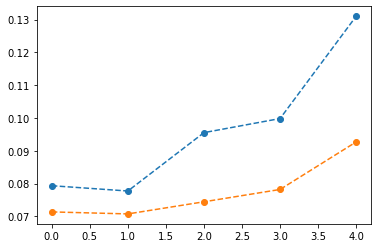

In [11]:
print(' ########## Train #############')
print(f'\t IO auto encoder RMS = {train_IO_auto.RMS(train):.4}, NRMS = {train_IO_auto.RMS(train)/np.std(test.y):.2%}')
print(f'\t SS      encoder RMS = {train_SS_encoder.RMS(train):.4}, NRMS = {train_SS_encoder.RMS(train)/np.std(test.y):.2%}')

print('\n ########## Test ############')
print(f'\t IO auto encoder     RMS = {test_IO_auto.RMS(test):4.04}, NRMS = {test_IO_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder     RMS = {test_SS_encoder.RMS(test):4.04}, NRMS = {test_SS_encoder.RMS(test)/np.std(test.y):.2%}')
print(f'\t IO auto encoder 5   RMS = {test_5_auto.RMS(test):4.4}, NRMS = {test_5_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder 5   RMS = {test_5_ss.RMS(test):4.4}, NRMS = {test_5_ss.RMS(test)/np.std(test.y):.2%}')
print(f'\t IO auto encoder 20  RMS = {test_20_auto.RMS(test):4.4}, NRMS = {test_20_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder 20  RMS = {test_20_ss.RMS(test):4.4}, NRMS = {test_20_ss.RMS(test)/np.std(test.y):.2%}')
print(f'\t IO auto encoder 50  RMS = {test_50_auto.RMS(test):4.4}, NRMS = {test_50_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder 50  RMS = {test_50_ss.RMS(test):4.4}, NRMS = {test_50_ss.RMS(test)/np.std(test.y):.2%}')
print(f'\t IO auto encoder 100 RMS = {test_100_auto.RMS(test):4.4}, NRMS = {test_100_auto.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS      encoder 100 RMS = {test_100_ss.RMS(test):4.4}, NRMS = {test_100_ss.RMS(test)/np.std(test.y):.2%}')
P = [test_IO_auto.RMS(test)/np.std(test.y),test_SS_encoder.RMS(test)/np.std(test.y),test_5_auto.RMS(test)/np.std(test.y),test_5_ss.RMS(test)/np.std(test.y),test_20_auto.RMS(test)/np.std(test.y),test_20_ss.RMS(test)/np.std(test.y),test_50_auto.RMS(test)/np.std(test.y),test_50_ss.RMS(test)/np.std(test.y),test_100_auto.RMS(test)/np.std(test.y),test_100_ss.RMS(test)/np.std(test.y)]
IO_performs = P[::2]
SS_performs = P[1::2]
plt.plot(IO_performs,'o--')
plt.plot(SS_performs,'o--')
plt.show()

## Validation simulation error during training

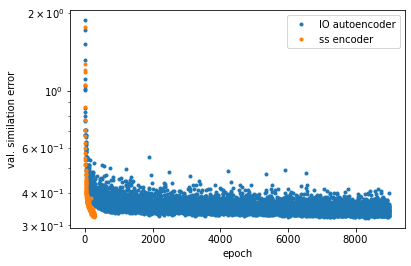

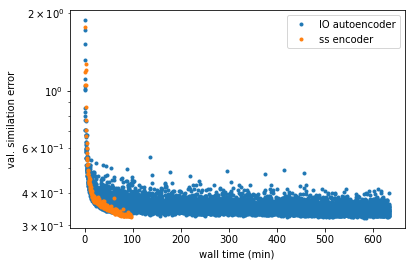

In [30]:
plt.semilogy(fit_sys_auto_last.Loss_val,'.')
plt.semilogy(np.array(fit_sys.Loss_val),'.')

plt.xlabel('epoch')
plt.ylabel('val. similation error')
plt.legend(['IO autoencoder','ss encoder'])
plt.show()

plt.semilogy(fit_sys_auto_last.time/60,fit_sys_auto_last.Loss_val,'.')
plt.semilogy(np.array(fit_sys.time)/60,np.array(fit_sys.Loss_val),'.')
plt.legend(['IO autoencoder','ss encoder'])
plt.xlabel('wall time (min)')
plt.ylabel('val. similation error')
plt.show()

## Figure 3: Time compare

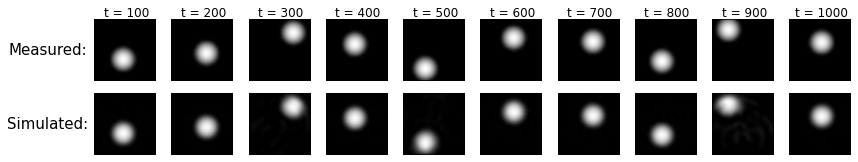

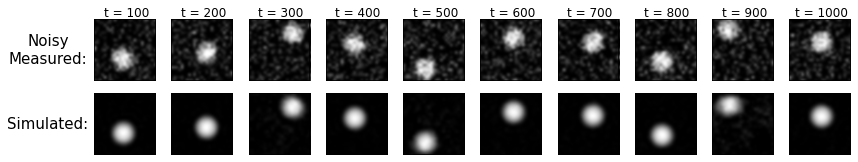

In [13]:
def make_figure(test,test_sim,name,Measured='Measured'):
    Xmax,Ymax = test.y[0].shape
    Y = test.y[100]
    def ball_show(Y,t,text=True):
        Y = np.clip(Y,0,1)
        plt.imshow(Y,cmap='gray',interpolation='bicubic',origin='lower')
        plt.plot(np.array([0,Ymax,Ymax,0,0])-0.5,np.array([0,0,Xmax,Xmax,0])-0.5,'k')
        if text: plt.text(Ymax/2,Xmax*1.075,'t = {}'.format(t),horizontalalignment='center',verticalalignment='center',fontdict=dict(size=12))
        plt.axis('off')
        #add other things


    offset = 26 #show extrapolation in 900
    tlist = list(range(100,1001,100))
    plt.figure(figsize=(15,2.5))
    plt.subplot(2,len(tlist)+1,1)
    plt.text(0.5,0.5,f'{Measured}:',horizontalalignment='center',verticalalignment='center',fontdict=dict(size=15))
    plt.axis('off')
    plt.subplot(2,len(tlist)+1,len(tlist)+1+1)
    plt.text(0.5,0.5,'Simulated:',horizontalalignment='center',verticalalignment='center',fontdict=dict(size=15))
    plt.axis('off')

    for k,t in enumerate(tlist):
        plt.subplot(2,len(tlist)+1,1+k+1)
        ball_show(test.y[t+offset],t)
        plt.subplot(2,len(tlist)+1,(1+len(tlist))+1+k+1)
        ball_show(test_sim.y[t+offset],t,text=False)
    # plt.tight_layout() #does not work
    plt.savefig(f'./figures/{name}.jpg',dpi=200)
    img0 = plt.imread(f'./figures/{name}.jpg')

    #manual tight layout
    img = np.mean(img0,axis=2)
    xdiffs = np.arange(img.shape[1])[np.mean(img,axis=0)<255]
    ydiffs = np.arange(img.shape[0])[np.mean(img,axis=1)<255]
    xmin,xmax = np.min(xdiffs), np.max(xdiffs)
    ymin,ymax = np.min(ydiffs), np.max(ydiffs)
    plt.imsave(f'./figures/{name}.jpg',img0[ymin-1:ymax+1,xmin-1:xmax+1])
    plt.show()
make_figure(test,test_SS_encoder,'strip')
make_figure(test_100,test_100_ss,'strip-100-noise',Measured='Noisy\nMeasured')

## Figure 4: Error in time

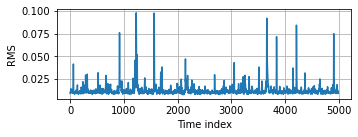

In [14]:
diff = (test_SS_encoder-test)
plt.figure(figsize=(5,2))
plt.plot(np.mean(diff.y[10:]**2,axis=(1,2))**0.5) 
plt.ylabel('RMS')
plt.xlabel('Time index')
plt.tight_layout()
plt.grid()
plt.savefig('./figures/time-square-error.pdf')
plt.show()

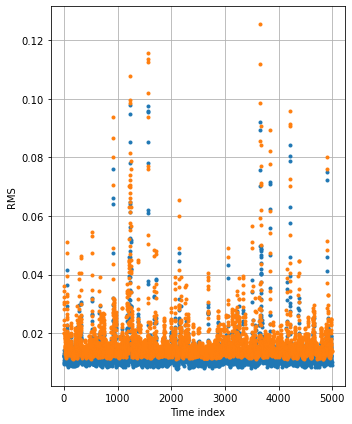

In [15]:
diff = (test_SS_encoder-test)
diff2 = (test_100_ss-test)
plt.figure(figsize=(5,6))
plt.plot(np.mean(diff.y[10:]**2,axis=(1,2))**0.5,'.') 
plt.plot(np.mean(diff2.y[10:]**2,axis=(1,2))**0.5,'.') 
plt.ylabel('RMS')
plt.xlabel('Time index')
plt.tight_layout()
plt.grid()
plt.savefig('./figures/time-square-error-noise.pdf')
plt.show()

## Figure 5: n-step error

The error one expect to find after taking n steps.

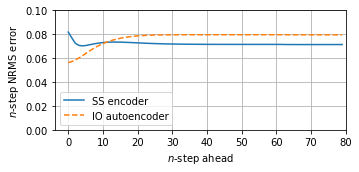

In [16]:
plt.figure(figsize=(5,2.5))
plt.plot(fit_sys.n_step_error(test.flatten(),RMS=False,nf=80),label='SS encoder') #uses the norm
plt.plot(fit_sys_auto.n_step_error(test.flatten(),RMS=False,nf=80),'--',label='IO autoencoder') #uses the norm
# plt.plot(fit_sys.n_step_error(train[:5000].flatten(),RMS=False,nf=80),label='train') #uses the norm
plt.ylim(0,0.1)
plt.ylabel('$n$-step NRMS error')
plt.xlabel('$n$-step ahead')
plt.tight_layout()
plt.legend()
plt.grid()
plt.savefig('./figures/n-step-error.pdf')
plt.xlim(None,80)
plt.show()


## Video's

In [17]:
#requires cv2

# test_predict.reshape_as(test).to_video(file_name='test-predict-ball-box-2')
# test.to_video(file_name='test-ball-box-2')
limit = 1500
test[:limit].to_video('videos/test-measured')
test_SS_encoder[:limit].to_video('videos/test-SS-encoder')
test_IO_auto[:limit].to_video('videos/test-IO-autoencoder')

#combined videos
System_data(y=np.concatenate((test.y,test_SS_encoder.y),axis=2))[:limit].to_video(file_name='videos/test-sim-measured-and-SS-encoder')
System_data(y=np.concatenate((test.y,test_SS_encoder.y,test_IO_auto.y),axis=2))[:limit].to_video(file_name='videos/test-sim-measured-SS-encoder-and-IO-auto-encoder')

In [18]:
limit = 1500
System_data(y=np.concatenate((test_5.y,test_5_ss.y),axis=2))[:limit].to_video(file_name='videos/noise5-ss')
System_data(y=np.concatenate((test_20.y,test_20_ss.y),axis=2))[:limit].to_video(file_name='videos/noise20-ss')
System_data(y=np.concatenate((test_50.y,test_50_ss.y),axis=2))[:limit].to_video(file_name='videos/noise50-ss')
System_data(y=np.concatenate((test_100.y,test_50_ss.y),axis=2))[:limit].to_video(file_name='videos/noise100-ss')
# System_data(y=np.concatenate((test_5.y,test_5_ss.y),axis=2))[:limit].to_video(file_name='videos/noise5-ss')

## Reproduceability @ nx=4

In [ ]:

if False:
    fit_sys_nx4_1 = get_fit_sys_ss(nx=4)
    fit_sys_nx4_1.fit(train.flatten(),verbose=2, epochs=350, loss_kwargs=dict(nf=50),sim_val=val.flatten())
    fit_sys_nx4_1.save_system('systems/SS-encoder-sys-nx4-1') #prevent accidental overwrite is bad
else:
    fit_sys_nx4_1 = deepSI.load_system('systems/SS-encoder-sys-nx4-1')

if False:
    fit_sys_nx4_2 = get_fit_sys_ss(nx=4)
    fit_sys_nx4_2.fit(train.flatten(),verbose=2, epochs=350, loss_kwargs=dict(nf=50),sim_val=val.flatten())
    fit_sys_nx4_2.save_system('systems/SS-encoder-sys-nx4-2') #prevent accidental overwrite is bad
else:
    fit_sys_nx4_2 = deepSI.load_system('systems/SS-encoder-sys-nx4-2')

if False:
    fit_sys_nx4_3 = get_fit_sys_ss(nx=4)
    fit_sys_nx4_3.fit(train.flatten(),verbose=2, epochs=350, loss_kwargs=dict(nf=50),sim_val=val.flatten())
    fit_sys_nx4_3.save_system('systems/SS-encoder-sys-nx4-3') #prevent accidental overwrite is bad
else:
    fit_sys_nx4_3 = deepSI.load_system('systems/SS-encoder-sys-nx4-3')
    
if False:
    fit_sys_nx6_1 = get_fit_sys_ss(nx=6)
    fit_sys_nx6_1.fit(train.flatten(),verbose=2, epochs=350, loss_kwargs=dict(nf=50),sim_val=val.flatten())
    fit_sys_nx6_1.save_system('systems/SS-encoder-sys-nx6-1') #prevent accidental overwrite is bad
else:
    fit_sys_nx6_1 = deepSI.load_system('systems/SS-encoder-sys-nx6-1')


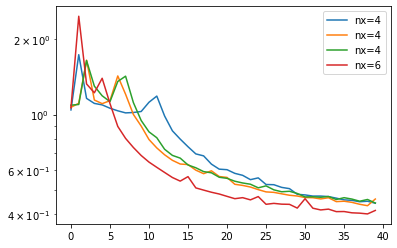

In [20]:
plt.semilogy(fit_sys_nx4_1.Loss_val[:40],label='nx=4')
plt.semilogy(fit_sys_nx4_2.Loss_val[:40],label='nx=4')
plt.semilogy(fit_sys_nx4_3.Loss_val[:40],label='nx=4')
plt.semilogy(fit_sys_nx6_1.Loss_val[:40],label='nx=6')
plt.legend()
plt.show()

In [21]:
test_nx4_1 = fit_sys_nx4_1.apply_experiment(test.flatten()).reshape_as(test)
test_nx4_2 = fit_sys_nx4_2.apply_experiment(test.flatten()).reshape_as(test)
test_nx4_3 = fit_sys_nx4_3.apply_experiment(test.flatten()).reshape_as(test)
test_nx6_1 = fit_sys_nx6_1.apply_experiment(test.flatten()).reshape_as(test)

In [22]:
print(f'\t SS  nx4  encoder     RMS = {test_nx4_1.RMS(test):4.04}, NRMS = {test_nx4_1.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS  nx4  encoder     RMS = {test_nx4_2.RMS(test):4.04}, NRMS = {test_nx4_2.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS  nx4  encoder     RMS = {test_nx4_3.RMS(test):4.04}, NRMS = {test_nx4_3.RMS(test)/np.std(test.y):.2%}')
print(f'\t SS  nx6  encoder     RMS = {test_nx6_1.RMS(test):4.04}, NRMS = {test_nx6_1.RMS(test)/np.std(test.y):.2%}')


	 SS  nx4  encoder     RMS = 0.01469, NRMS = 7.19%
	 SS  nx4  encoder     RMS = 0.01512, NRMS = 7.39%
	 SS  nx4  encoder     RMS = 0.01537, NRMS = 7.52%
	 SS  nx6  encoder     RMS = 0.01475, NRMS = 7.21%
